In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.decomposition import NMF
import math as Math

In [2]:
data=pd.read_csv(r"E:\Documents\University of Hildesheim\Machine learning lab\lab10\ml-100k\u.data",sep=r"\s+",
                 names=["userId","itemId","rating","timestamp"])
data.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
def predict(matrix_,matrix,test):
    yhat=[]
    dval=[]
    for i in range (0,len(test)):
        flag=1
        if(test.iloc[i]['userId'] in matrix_.index):
            f=matrix_.index.get_loc(test.iloc[i]['userId'])
        else:
            f=-1
        if(test.iloc[i]['itemId'] in matrix_.columns):
            t=matrix_.columns.get_loc(test.iloc[i]['itemId'])
        else:
            t=-1
        if(f==-1 or t==-1):
            dval.append(i)
        else:
            
            yhat.append(matrix[f][t])
    return yhat,test.drop(test.index[dval])

In [4]:
def RMSE(y,yhat):
    rmse =Math.sqrt(np.sum(pow((y-yhat),2))/len(y))
    return rmse

In [5]:
def data_k_divide(data,k):
    k_size=Math.floor(len(data)/k)
    k_data=[] 
    c=0
    for i in range (0,k):
        data_set=pd.DataFrame(data.head(0))
        for j in range(i*k_size,(i*k_size)+k_size):
            data_set=data_set.append(data.iloc[j])
            c=c+1
        k_data.append(data_set)
        
    #adding datas which are remaining at the end of k division
    for j in range(c,len(data)):
        k_data[k-1]=k_data[k-1].append(data.iloc[j])
    return k_data

def k_data_train_test(x,k):
    k_folded_data=[]
    for i in range(0,k):
        x_test=x[i]
    
        x_train=pd.DataFrame()
        
        for j in range(0,k):
            if i!=j:
                x_train=x_train.append(x[j])
                
        final_data=dict([('x_train',x_train),('x_test',x_test)])
        k_folded_data.append(final_data)
    return k_folded_data
    
def kfold(x_train,k,alpha,lamda):
    rmse=[]
    x_train_k=data_k_divide(x_train,k)
    kdata=k_data_train_test(x_train_k,k)
    for i in range(0,k):
        rMatrix=kdata[i]['x_train'].pivot(index='userId',columns='itemId',values='rating')
        rMatrix=rMatrix.replace(np.nan,0)
        model = NMF(n_components=3, init='random',solver='cd',beta_loss='frobenius',alpha=alpha,l1_ratio=lamda,
                    max_iter=200,random_state=0)
        W = model.fit_transform(rMatrix)
        H = model.components_
        finalmat=W.dot(H)
        yhat,y=predict(rMatrix,finalmat,kdata[i]['x_test'])
        rmse.append(RMSE(y['rating'],yhat))
    return sum(rmse)/k

In [6]:
def gridsearch(alpha,lamda):
    comb=[]
    for i in range(0,len(alpha)):
        for k in range(0,len(lamda)):
            comb.append(dict([('alpha',alpha[i]),('lamda',lamda[k])]))
    return comb

In [7]:
alpha=[0.1,0.0000001]
l1=[0.1,0.0001]
grid=gridsearch(alpha,l1)
rmsearr=[]
for i in range (0,len(grid)):
    rmse=kfold(data,3,grid[i]["alpha"],grid[i]["lamda"])
    print("testrmse:" ,rmse,"for k values of :",grid[i])
    rmsearr.append(rmse)

testrmse: 3.095214233411966 for k values of : {'alpha': 0.1, 'lamda': 0.1}
testrmse: 3.095196327651466 for k values of : {'alpha': 0.1, 'lamda': 0.0001}
testrmse: 3.095027264041237 for k values of : {'alpha': 1e-07, 'lamda': 0.1}
testrmse: 3.095027264023562 for k values of : {'alpha': 1e-07, 'lamda': 0.0001}


### The rmse score is not better than the before the local bais and global bais is not being considered in the model

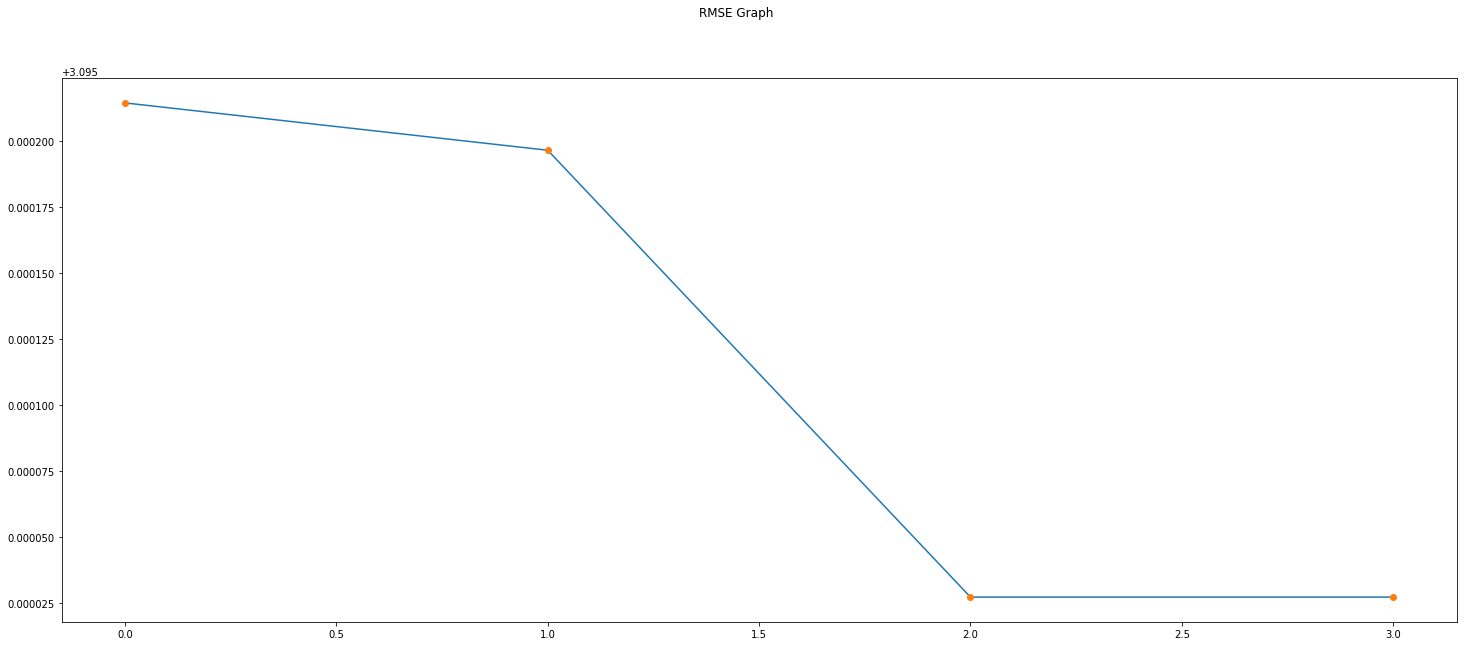

In [9]:
fig,axs=plt.subplots(1,1,figsize=(25,10))
fig.suptitle("RMSE Graph")
axs.plot(rmsearr)
axs.plot(rmsearr,'o')
plt.show()

### After Analyzing the graph we can see that the rmse decreased 